In [1]:
import pyemma
import numpy as np
import pyemma.coordinates as coor
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
from matplotlib.pyplot import cm
from collections import OrderedDict
import mdtraj as md
import itertools
import time
import indices
from indices.base import BaseComparisons as bc
from indices.faith import Faith as Fai
import scipy.cluster.hierarchy as shc
from matplotlib import gridspec
from matplotlib import pyplot
import mdtraj
import seaborn as sns

## Let's try it...

In [52]:
Threshold = 0.6
traj = md.load_dcd('test_data/protein/3gb1.dcd',top='test_data/protein/3GB1.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load('test_data/protein/3gb1.dcd', features=feat)
inp=inp[::10]
traj = traj[::10]
traj_index = [i for i in range(traj.n_frames) if i not in index_aa]
inp=inp[traj_index]
traj = traj[traj_index]

In [18]:
inp=inp[::10]

In [53]:
# %%timeit -n1 -r1 

all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')


###calculate similarity
simi = all_c[:,0]+all_c[:,2]
###try Faith
Faith=False
if Faith:
    faith_simi = 0.5*all_c[:,0]+all_c[:,2]
    denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
    w_p = faith_simi/denominate
    simi_matrix = np.zeros((len(inp),len(inp)))
    indices = np.triu_indices(len(inp),k=1)
    indices = (indices[1],indices[0])
    simi_matrix[indices] = w_p
else:
    simi_matrix = np.zeros((len(inp),len(inp)))
    indices = np.triu_indices(len(inp),k=1)
    indices = (indices[1],indices[0])
    simi_matrix[indices] = simi
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (397386, 3)
step 0 time = 1.7 s
final matrix shape =  (892, 892)
total time = 1.74 s


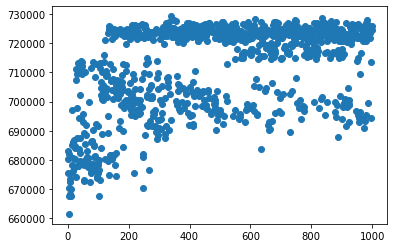

In [20]:
#np.unravel_index(np.argmax(simi, axis=None),simi.shape)
simi_matrix
mirror_binary_simi=simi_matrix+np.rot90(np.fliplr(simi_matrix))
sum_mirror_binary_simi = np.sum(mirror_binary_simi.T,axis=1)
sum_mirror_binary_simi_index = np.vstack((sum_mirror_binary_simi,range(len(sum_mirror_binary_simi)))).T
plt.scatter(range(sum_mirror_binary_simi.shape[0]),sum_mirror_binary_simi)
index_aa=[]
for index_a,i in enumerate(sum_mirror_binary_simi_index[:,0]):
    if sum_mirror_binary_simi[index_a] < 690000:
        index_aa.append(index_a)

In [54]:
import pandas  as pd
all_start=time.time()
df = pd.DataFrame(simi_matrix,columns=pd.MultiIndex.from_tuples([('{}'.format(i),'{}'.format(i)) for i in range(1,len(inp)+1)],names=['cluster', 'frame']))
inp_copy=inp
dic={}
hie_tree=[]
dentrom=[]
time_step=[]
while df.shape[0] > 2:
    ###update df
    frame_column=[i[1] for i in df.columns.to_list()]
    hie_tree.append(frame_column)
    new_max=np.argmax(df, axis=None)     ###2.5s

    del_index = np.unravel_index(new_max, df.shape)
    max_value = df.to_numpy()[del_index[0]][del_index[1]] ###0.1s

    ###get temp inp
    delete_row=[int(i) for i in df.columns[del_index[0]][1].split(',') ]
    delete_cluster_row=[int(i) for i in df.columns[del_index[0]][0].split(',')]
    delete_column=[int(i) for i in df.columns[del_index[1]][1].split(',') ]
    delete_cluster_column=[int(i) for i in df.columns[del_index[1]][0].split(',')]
    dentrom.append([*delete_cluster_column,*delete_cluster_row])

    delete_all=delete_column+delete_row
    insert_index='{}'.format(delete_all)[1:-1]   ###0.1s
    insert_cluster_index='{}'.format(2*len(inp) - df.shape[0]+1)
    df.drop(columns=[('{}'.format(delete_cluster_column)[1:-1],'{}'.format(delete_column)[1:-1]),('{}'.format(delete_cluster_row)[1:-1],'{}'.format(delete_row)[1:-1])],axis=1,inplace=True)
    df.drop(index=[*del_index],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    temp_w_sim=[]            ###1s

    ###get temp inp
   # print(df.columns)
    frame_column=[i[1] for i in df.columns.to_list() ]
    columns=[[int(d) for d in [*i.split(',')]] for i in frame_column]
    temp_inp=[[inp_copy[d-1] for d in m] for m in columns]    ###0.1s

    ###perform comparison
#     if Faith:
#         for i in temp_inp:
#             compare=Fai(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
#             temp_w_sim.append(compare.Fai_1sim_wdis)
#     else:
    for i in temp_inp:
        compare=bc(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
        temp_w_sim.append(compare.total_w_sim)         ###1s

#     temp_start = time.time()
  #  inp_copy = temp_inp
    temp_w_sim=[0]+temp_w_sim
    df.loc[-1] = [0]*df.shape[1] # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index
   # print(df.shape)
    if df.shape[0] % 100 == 0:
        all_end = time.time()
        all_time = all_end - all_start
        print('merge {} clusters time ='.format(df.shape[0]), round(all_time,2),'s')
        time_step.append(round(all_time,4))
    df.insert(loc=0, column=(insert_cluster_index,insert_index), value=temp_w_sim)

    dic[insert_index]=max_value
temp_end = time.time() 
temp_time = temp_end - all_start          
print('merge {} clusters time ='.format(df.shape[0]), round(temp_time,2),'s')
time_step.append(round(temp_time,4))
last_two = [int(i[0]) for i in df.columns.to_list()]
dentrogram = np.vstack(dentrom)-np.ones((1,2))
values = np.max(simi_matrix)-np.array([*dic.values()],ndmin=2)+2
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
tree = np.hstack((dentrogram,values.T,num_frames.T))
tree = np.vstack((tree, [[last_two[0]-1,last_two[1]-1,np.max(simi_matrix)-df.to_numpy()[1][0],len(inp)]]))

merge 800 clusters time = 6.53 s
merge 700 clusters time = 13.32 s
merge 600 clusters time = 19.15 s
merge 500 clusters time = 24.82 s
merge 400 clusters time = 29.86 s
merge 300 clusters time = 34.46 s
merge 200 clusters time = 38.45 s
merge 100 clusters time = 42.12 s
merge 2 clusters time = 45.34 s


In [55]:
def plot_simi_threshold(tree,p,min_simi,save=False):
    plt.figure(figsize=(20, 8))
    dend = shc.dendrogram(tree,p=p,truncate_mode='lastp')
    plt.axhline(y=min_simi, color='r', linestyle='-')
    plt.xlabel('Num_samples')
    plt.ylabel('Simi_value')
    if save:
        plt.savefig('simi_threshold_tree.png')
def plot_test_result(true_rmsd,hie_tree,cluster_step,save=False):
    colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
             'black','brown','navy','indigo','cyan','teal','violet','royalblue']
    fig, ax = plt.subplots(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    label_index = sorted(label_index, key=lambda x:len(x), reverse=True)
    if len(label_index) > 10:
        label_index = label_index[:10]
    test_rmsd = [[true_rmsd[i] for i in label_index[d]] for d in range(len(label_index))]
    for index,i in enumerate(test_rmsd):
        ax0.scatter(label_index[index],i,marker='.',color=colors[index])
    percentage=[len(i)/len(true_rmsd) for i in test_rmsd]
    sum_percentage = [0.0]+[sum(percentage[:i]) for i in range(1,len(percentage))]+[1.0]
    ax0.set_xlabel('Sample')
    ax0.set_ylabel('RMSD')
    cmap = mpl.colors.ListedColormap(colors[:len(test_rmsd)])
    print(colors[:len(test_rmsd)])
    norm = mpl.colors.BoundaryNorm(sum_percentage, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=sum_percentage,
                                    ticks=sum_percentage+[1.0],
                                    spacing='proportional')
    cb2.set_label('Cluster samples ratio')
    if save:
        plt.savefig('simi_threshold_tree.png')
    return label_index

['grey', 'purple', 'blue', 'green', 'orange', 'red']


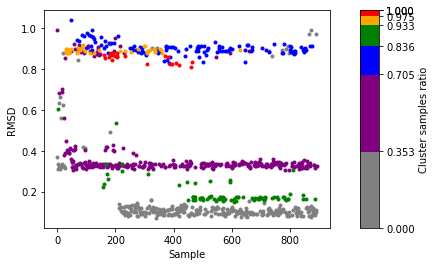

In [64]:
# traj = md.load_dcd('test_data/protein/3gb1.dcd',top='test_data/protein/3GB1.pdb')
# topfile=traj.top
# pdb=md.load_pdb('test_data/protein/3GB1.pdb')
# all_CA=topfile.select("backbone==1")
# traj=traj[::10]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
label_index = plot_test_result(true_rmsd,hie_tree,-4)
#plt.scatter(range(len(true_rmsd)),true_rmsd)
#plt.scatter(index_aa,true_rmsd[index_aa],color='r')

In [42]:
len(index_aa)

108

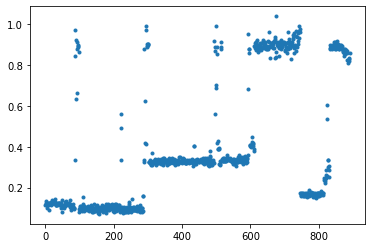

In [66]:
label_concate = np.concatenate(label_index)
# traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
# topfile=traj.top
# pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
# all_CA=topfile.select("backbone==1")
traj_cluster=traj[label_concate]
cluster_rmsd=md.rmsd(traj_cluster,pdb,atom_indices=all_CA)
plt.scatter(range(len(cluster_rmsd)),list(cluster_rmsd),marker='.')
#plt.ylim(0,2)

0
100
200
300
400
500
600
700
800
(398278,)


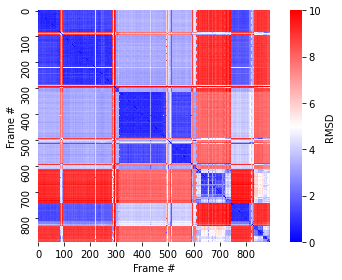

In [67]:
rmsd_2d=np.zeros((len(traj_cluster),len(traj_cluster)))
upper_indices = np.triu_indices(len(traj_cluster),k=0)
lower_indices = (upper_indices[1],upper_indices[0])
r2d = []
for i in range(len(traj_cluster)):
    r2d.append(md.rmsd(traj_cluster[i:],traj_cluster[i],atom_indices=all_CA))
    if i % 100 == 0:
        print(i)
print(np.concatenate(r2d).shape)
rmsd_2d[lower_indices] = np.concatenate(r2d)
rmsd_2d[upper_indices] = np.concatenate(r2d)
sns.heatmap(rmsd_2d*10,square=True,xticklabels=100,yticklabels=100,cmap='bwr',cbar_kws={'label':'RMSD'},vmin=0,vmax=10)
plt.xlabel("Frame #")
plt.ylabel("Frame #")
ax = plt.gca()
ax.tick_params(direction='out')
plt.tight_layout()
#plt.savefig('test_Faith_1000samples_-40cluster_2drmsd.png')

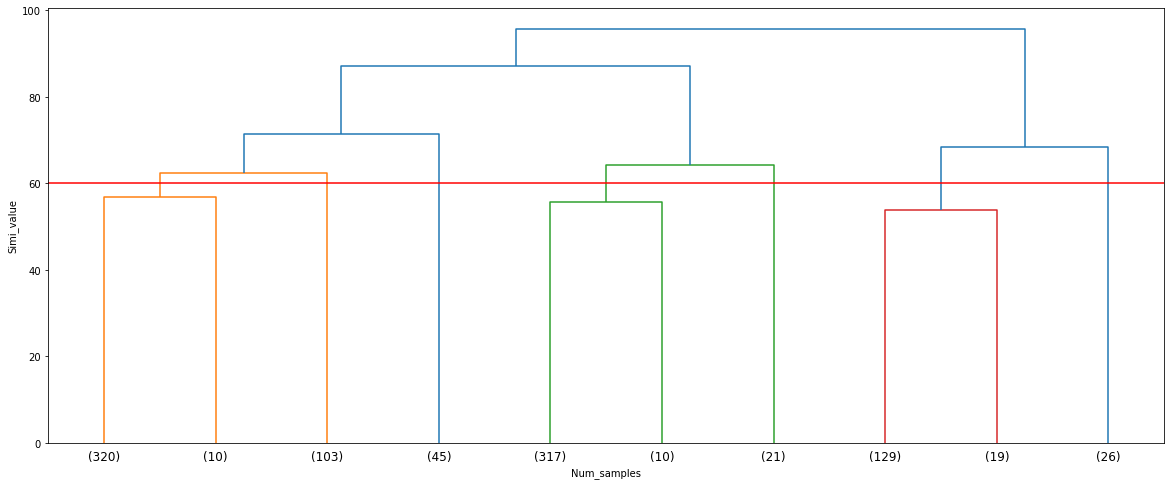

In [94]:
plot_simi_threshold(tree,10,60)

(0.0, 1.5)

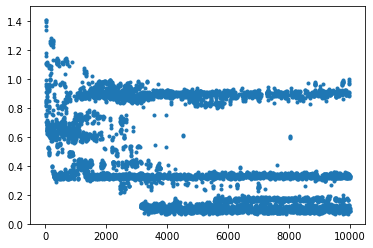

In [142]:
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
len(traj)
all_CA=topfile.select("backbone==1")
all_CA
rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#list(rmsd)
plt.scatter(range(len(rmsd)),list(rmsd),marker='.')
plt.ylim(0,1.5)

Text(0, 0.5, 'RMSD')

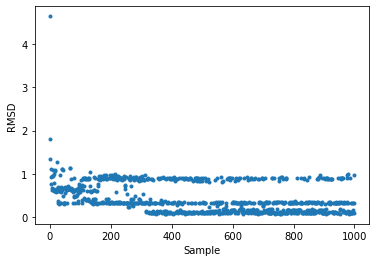

In [143]:
traj=traj[::10]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#list(rmsd)
plt.scatter(range(len(true_rmsd)),list(true_rmsd),marker='.')
plt.xlabel('Sample')
plt.ylabel('RMSD')

In [15]:
def correct_ratio(x):
    unfold = np.sum((x>0.8) & (x<1.8))/x.shape[0]
    intermediate = np.sum((x>0.25) & (x<0.45))/x.shape[0]
    fold = np.sum((x>0.0) & (x<0.25))/x.shape[0]
    molten = np.sum((x>0.45) & (x<0.8))/x.shape[0]
    other = 1-unfold-intermediate-fold-molten
    ratio = [round(unfold,4),round(intermediate,4),round(fold,4),round(molten,4),round(other,4)]
    return ratio

In [68]:
all_clust=[[int(d) for d in [*i.split(',')]] for i in list(dic.keys())]
ave_rmsd = []
all_rmsd = []
for index,i in enumerate(all_clust):
    
    traj_comp=traj[[np.array(i)-1]]
    rmsd=md.rmsd(traj_comp,pdb,atom_indices=all_CA)
    ave_rmsd.append(np.average(rmsd))
    all_rmsd.append(rmsd)
    if index % 100 == 0:
        print(index)
    #print(rmsd)

/home/liwei/Prorgram/miniconda3/envs/msm/lib/python3.7/site-packages/mdtraj/core/trajectory.py:1129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xyz = self.xyz[key]
/home/liwei/Prorgram/miniconda3/envs/msm/lib/python3.7/site-packages/mdtraj/core/trajectory.py:1130: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time = self.time[key]


0
100
200
300
400
500
600
700
800


In [146]:
correct_ratio(true_rmsd)

[0.252, 0.307, 0.349, 0.091, 0.001]

In [69]:
accuracy=[]
for i in range(len(all_rmsd)):
    if len(all_rmsd[i])>1:
        ratio = correct_ratio(all_rmsd[i])
        print(len(all_rmsd[i]),ratio)#,'|',[*dic.keys()][i])
        accuracy.append(np.max(ratio))

2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
4 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.

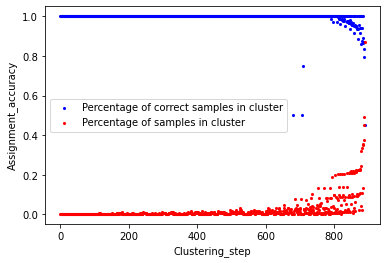

In [71]:
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
plt.scatter(range(len(accuracy)),accuracy,marker='.',linewidths=0.1,color='b',label='Percentage of correct samples in cluster')
plt.scatter(range(num_frames.shape[1]),*(num_frames/num_frames.shape[1]).tolist(),marker='.',linewidths=0.1,color='r',label='Percentage of samples in cluster')
#plt.scatter(*(num_frames).tolist(),accuracy,marker='.',color='r')

plt.xlabel('Clustering_step')
plt.ylabel('Assignment_accuracy')
plt.legend()
plt.savefig('test_Faith_proteinG_1000samples_without_outlier_accuracy.png')

In [189]:
for i in range(-10,0):
    print(len(all_clust[i]),'|',round(ave_rmsd[i],3),'|',round([*dic.values()][i],3))

125 | 0.586 | 758.328
79 | 0.602 | 758.101
25 | 0.571 | 758.08
12 | 0.78 | 757.833
89 | 0.599 | 757.629
16 | 0.541 | 757.625
185 | 0.632 | 757.6
12 | 0.656 | 757.5
191 | 0.579 | 757.257
2 | 0.971 | 757.0


In [112]:
len([*[*dic.keys()][99].split(',')])

897

## We will try k-means++ from here

In [28]:
Threshold = 0.6
traj = md.load_dcd('test_data/protein/3gb1.dcd',top='test_data/protein/3GB1.pdb')
topfile=traj.top
pdb = md.load_pdb('test_data/protein/3GB1.pdb')
feat = coor.featurizer(topfile)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load('test_data/protein/3gb1.dcd', features=feat)
inp=inp[::10]
traj = traj[::10]
traj_index = [i for i in range(traj.n_frames) if i not in index_aa]
inp=inp[traj_index]
traj = traj[traj_index]

In [29]:
all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')

###calculate similarity
simi = all_c[:,0]+all_c[:,2]
disimi = all_c[:,1]
denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
w_p = simi/denominate
simi_matrix = np.zeros((len(inp),len(inp)))
mirror_simi_matrix = np.zeros((len(inp),len(inp)))
upper_indices = np.triu_indices(len(inp),k=1)
lower_indices = (upper_indices[1],upper_indices[0])
simi_matrix[lower_indices] = simi
mirror_simi_matrix[upper_indices] = simi
mirror_simi_matrix[lower_indices] = simi
np.fill_diagonal(mirror_simi_matrix,np.Inf)
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (397386, 3)
step 0 time = 1.72 s
final matrix shape =  (892, 892)
total time = 1.76 s


In [33]:
traj_index.index(382)

277

In [34]:
#centroid = np.random.randint(0,len(inp),3)
centroid = [148,697,277]

In [35]:
### Assigning the most similar sample to each centroid
mirror_max_matrix = np.zeros((len(inp),len(inp)))
mirror_max_matrix[upper_indices] = simi
mirror_max_matrix[lower_indices] = simi
max_index = np.argmax(mirror_max_matrix[:,centroid],axis=0)
first_step = [[centroid[index],max_index[index]] for index in range(len(max_index))]
second_step_index = [i for i in range(inp.shape[0]) if i not in list(np.concatenate(first_step))]
print(first_step)

[[148, 121], [697, 686], [277, 806]]


In [36]:
all_CA=topfile.select("backbone==1")
md.rmsd(traj[np.concatenate(first_step)],pdb,atom_indices=all_CA)

array([0.87399685, 0.8820699 , 0.33895   , 0.33139157, 0.07938181,
       0.08370326], dtype=float32)

In [37]:
all_start = time.time()
k_clusters = first_step
while len(second_step_index) > 0:
    random_int = np.random.randint(0,len(second_step_index))
    single = second_step_index[random_int]
    k_max = np.argmax([bc(np.concatenate(([inp[single]],inp[k_clusters[k]]),axis=0)).total_w_sim for k in range(len(k_clusters))],axis=None)
#    k_max = np.argmax([Fai(np.concatenate(([inp[single]],inp[k_clusters[k]]),axis=0)).Fai_1sim_wdis for k in range(len(k_clusters))],axis=None)
    k_clusters[k_max] = k_clusters[k_max] + [single]
    second_step_index.remove(single)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

total time = 2.18 s


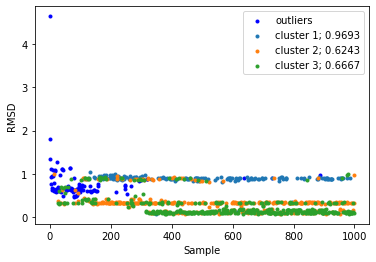

In [51]:
traj = md.load_dcd('test_data/protein/3gb1.dcd',top='test_data/protein/3GB1.pdb')
topfile=traj.top
pdb = md.load_pdb('test_data/protein/3GB1.pdb')
traj = traj[::10]
out_lier = md.rmsd(traj[index_aa],pdb,atom_indices=all_CA)
plt.scatter(index_aa,out_lier,marker='.',color='b',label='outliers')
traj_index = [i for i in range(traj.n_frames) if i not in index_aa]
#traj = traj[traj_index]
ori_index = [[traj_index[i] for i in d] for d in k_clusters]
for index,i in enumerate(ori_index):
    true_rmsd=md.rmsd(traj[i],pdb,atom_indices=all_CA)
    plt.scatter(i,true_rmsd,marker='.',label='cluster {0}; {1}'.format(index+1,max(ratio[index])))
plt.legend()
plt.xlabel('Sample')
plt.ylabel('RMSD') 
plt.savefig('test_1000samples_kmeans_1drmsd.png')

In [49]:
print([len(i) for i in k_clusters])
ratio=[correct_ratio(md.rmsd(traj[i],pdb,atom_indices=all_CA)) for i in ori_index]

[163, 354, 375]


In [ ]:
### compare triple array
for k in range(len(first_step)):
    a=np.zeros((len(second_step_index),len(first_step[k])+1))
    a[:,0] = second_step_index
    a[:,[1,2]] = first_step[k]
    a=a.astype('int')
    all_input = [inp[i] for i in a]
    all_array_input = np.vstack([all_input])
    all_product = all_array_input.reshape(-1,3,all_array_input.shape[-1]).sum(1)
    temp_c = np.zeros((len(second_step_index),len(first_step[0])+2))
    for row in range(len(first_step[0])+2):
        temp_c[:,row] = np.sum(all_product==row,axis=1)
    if k == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
        
### find centroids step by step
min_index = (np.argmin(mirror_simi_matrix[:,first_centroid]),first_centroid)
centroid = [first_centroid]
k=2
for i in range(k):
    ave_array = np.average(mirror_simi_matrix[:,centroid],axis=1)
    print(ave_array.shape)
    min_index = np.argmin(ave_array)
    centroid.append(min_index)
    print(centroid)
centroid

## Here is the playground

In [4]:
all_data=np.loadtxt('test_data/origin_1000.dat')
all_data=all_data[:,0:2]#[np.random.randint(0,1000,900)]
pairs = list(itertools.combinations(all_data, 2))

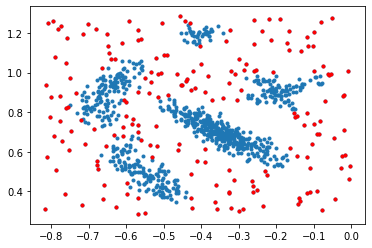

In [13]:
plt.scatter(all_data[:,0],all_data[:,1],marker='.')
#plt.scatter(all_data[:,0][0],all_data[:,1][0],marker='.',color='r')
plt.scatter(all_data[:,0][index_aa],all_data[:,1][index_aa],marker='.',color='r')
#plt.scatter(all_data[:,0][sorted_sum_mirror_binary_simi_index[:,1][:20]],all_data[:,1][sorted_sum_mirror_binary_simi_index[:,1][:20]],marker='.',color='r')
plt.savefig('test_origin_1000_dataset_margin.png')

In [4]:
def min_distance(x,threshold):
    pairs = list(itertools.combinations(x, 2))
    pair_array = np.array(pairs)
    distance=np.linalg.norm(pair_array[:,0]-pair_array[:,1],axis=1)
    distance_cut=[distance>1]
    return

In [6]:
#pairs = list(itertools.combinations(, 2))
simi_matrix = np.zeros((len(all_data),len(all_data)))
mirror_simi_matrix = np.zeros((len(all_data),len(all_data)))
upper_indices = np.triu_indices(len(all_data),k=1)
lower_indices = (upper_indices[1],upper_indices[0])
pair_array = np.array(pairs)
distance=np.linalg.norm(pair_array[:,0]-pair_array[:,1],axis=1)
distance_cut=distance<0.05
simi_matrix[lower_indices] = distance_cut
mirror_simi_matrix[upper_indices] = distance_cut
mirror_simi_matrix[lower_indices] = distance_cut
np.fill_diagonal(mirror_simi_matrix,1)
print(mirror_simi_matrix.T)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
from clustering import *
simi_matrix , _, time= binary_simi_matrix(mirror_simi_matrix)
mirror_binary_simi=simi_matrix+np.rot90(np.fliplr(simi_matrix))
sum_mirror_binary_simi = np.sum(mirror_binary_simi.T,axis=1)

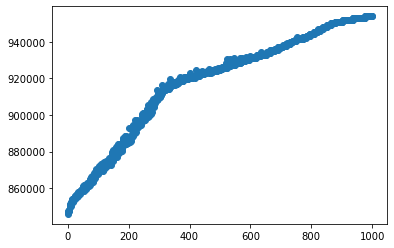

In [11]:
sum_mirror_binary_simi_index = np.vstack((sum_mirror_binary_simi,range(len(sum_mirror_binary_simi)))).T
plt.scatter(range(sum_mirror_binary_simi.shape[0]),sum_mirror_binary_simi)
index_aa=[]
for index_a,i in enumerate(sum_mirror_binary_simi):
    if 945000<sum_mirror_binary_simi[index_a]:# < 620000:
        index_aa.append(index_a)

In [8]:
sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()][::-1]
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
sorted_sum_mirror_binary_simi_index

array([[768776,    848],
       [768776,    375],
       [768776,    119],
       ...,
       [676306,    518],
       [674016,    736],
       [674016,    391]])

In [9]:
all_compare=[]
for i in range(1,len(all_data)):
    all_compare+=list(itertools.combinations(np.vstack((mirror_simi_matrix[sorted_sum_mirror_binary_simi_index[:,1][i]],mirror_simi_matrix[[sorted_sum_mirror_binary_simi_index[:,1][:i]]])),2))[:i]

/home/liwei/Prorgram/miniconda3/envs/msm/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
all_input = all_compare
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
#    product = np.linalg.norm(temp_input[:,0]-temp_input[:,1],axis=1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)

###calculate similarity

simi = all_c[:,0]+all_c[:,2]
dis_simi = all_c[:,1] #- all_c[:,2] - all_c[:,0]

simi_matrix = np.zeros((len(all_data),len(all_data)))
dis_simi_matrix = np.zeros((len(all_data),len(all_data)))
indices = np.triu_indices(len(all_data),k=1)
indices = (indices[1],indices[0])
simi_matrix[indices] = simi
dis_simi_matrix[indices] = simi

In [81]:
upper_indices = np.triu_indices(len(all_data),k=1)
dis_simi_matrix[upper_indices] = np.Inf
np.fill_diagonal(dis_simi_matrix,np.Inf)
#min_dis_simi = np.array([dis_simi_matrix[i].sum()/i for i in range(len(all_data))])#,axis=1)
min_dis_simi = np.min(dis_simi_matrix,axis=1)
min_dis_simi[0] = min_dis_simi[1:].max()
#dis_simi_matrix[0] = dis_simi_matrix.max()
dis_all = np.vstack((min_dis_simi,sorted_sum_mirror_binary_simi_index[:,1])).T

In [82]:
sorted_dis_all = dis_all[dis_all[:,1].argsort()]
sorted_dis_all

array([[779.,   0.],
       [763.,   1.],
       [760.,   2.],
       ...,
       [748., 785.],
       [737., 786.],
       [740., 787.]])

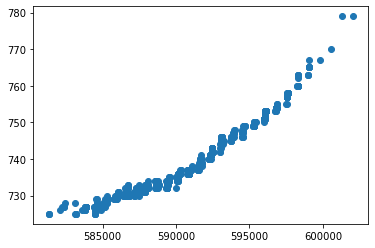

In [83]:
plt.scatter(sum_mirror_binary_simi,sorted_dis_all[:,0])

In [93]:
index_aa=[]
for index_a,i in enumerate(sorted_dis_all[:,0]):
    if 592000<sum_mirror_binary_simi[index_a] < 620000:
        index_aa.append(index_a)
        

In [79]:
sorted_dis_all[381]#.sum()#==mirror_simi_matrix[381]

array([  2.26770809, 381.        ])

In [78]:
index_aa

[311, 381]